In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a FourFeature model that has the same basic structure as the TwoFeature 6 convolutional layer  model. The differences/similarlities are:

  [1]  the FourFeature model has four channels of input rather than two.
  [2]  the extra two channels are added by using load_xy=True in collect_data (x2)
  [3]  the pretrained_dict is used with strict=False
  
In the first iterations, the weights from a trained TwoFeature_CNN6Layer_A model should be reused for the (X,Xsq) part of the algorithm, and the algorithm should only learn the filter for the (perturbative) (x,y) features.
  
Once the perturbative filters are beng generated, the algorithm can start with weights from a previous iteration of this algorithm and all weights free to float.

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jun  3 10:38:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 37%   47C    P8    25W / 250W |   5835MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 40

# Name is the output file name


##  190810  mds
folder = '01June2020_CNN5Layer_Ca_40epochs_K'
name = '01June2020_CNN5Layer_Ca_40epochs_K'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_01June20 import SimpleCNN5Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('dataAA/Aug14_80K_train.h5',
                            'dataAA/Oct03_80K_train.h5',
##                            'dataAA/Oct03_80K2_train.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('dataAA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded dataAA/Aug14_80K_train.h5 in 14.12 s
Loaded dataAA/Oct03_80K_train.h5 in 14.47 s
Constructing 160000 event dataset took 0.5949 s
Loading data...
Loaded dataAA/Oct03_20K_val.h5 in 3.118 s
Constructing 9984 event dataset took 3.343 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Linear(in_features=4000, out_features=4000, bias=True)


In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('ML/Aug17_FourFeature_CNN6LayerPlus_TargetsAA_Loss_A_1p0_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


In [12]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


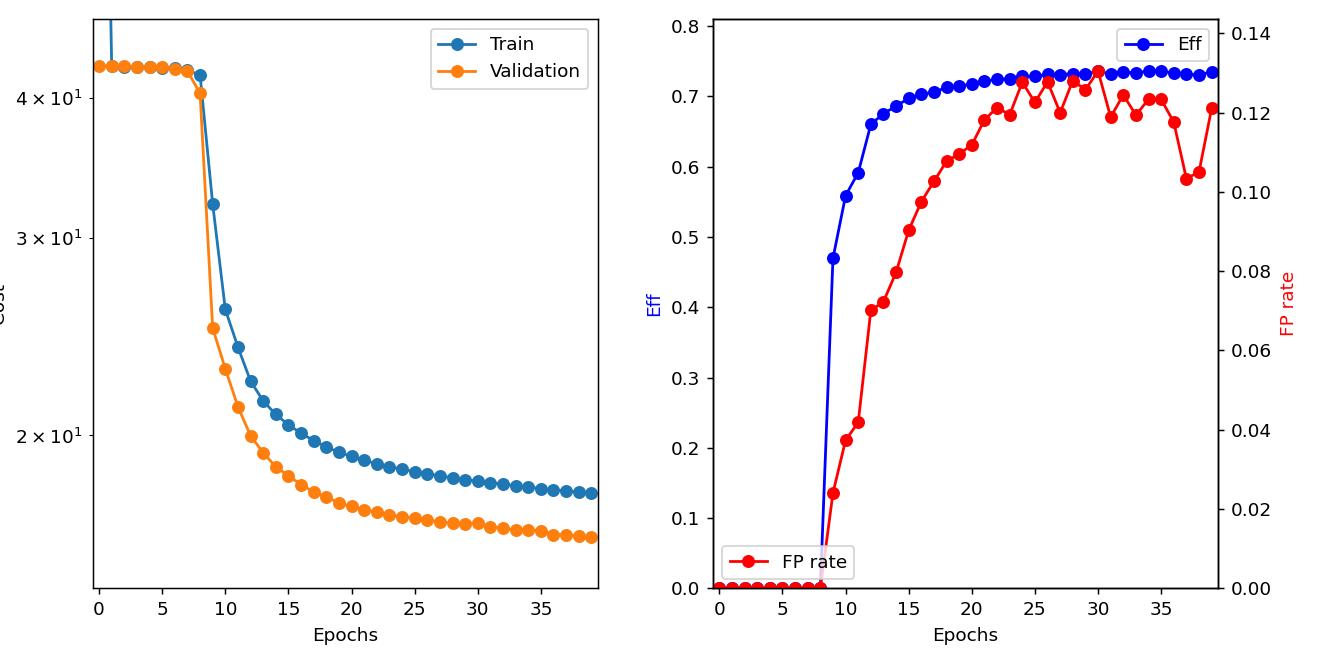

In [13]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [14]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 78


Epoch 0: train=169.788, val=42.6957, took 29.071 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=42.6389, val=42.6656, took 27.696 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=42.6106, val=42.6462, took 26.222 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 3: train=42.5927, val=42.623, took 26.172 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 4: train=42.5668, val=42.5956, took 26.053 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 5: train=42.5435, val=42.5731, took 25.941 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 6: train=42.4859, val=42.4231, took 25.761 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 7: train=42.3075, val=42.2352, took 25.841 s
  Validation Found 6 of 54504, added 2 (eff 0.01%) (0.0002 FP/event)


Epoch 8: train=41.9053, val=40.3442, took 25.682 s
  Validation Found 1 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 9: train=32.1548, val=24.928, took 25.655 s
  Validation Found 25601 of 54504, added 240 (eff 46.97%) (0.024 FP/event)


Epoch 10: train=25.902, val=22.934, took 25.622 s
  Validation Found 30458 of 54504, added 373 (eff 55.88%) (0.0374 FP/event)


Epoch 11: train=23.9779, val=21.2196, took 25.798 s
  Validation Found 32240 of 54504, added 418 (eff 59.15%) (0.0419 FP/event)


Epoch 12: train=22.3637, val=19.9859, took 26.775 s
  Validation Found 35987 of 54504, added 700 (eff 66.03%) (0.0701 FP/event)


Epoch 13: train=21.4709, val=19.3098, took 26.705 s
  Validation Found 36813 of 54504, added 722 (eff 67.54%) (0.0723 FP/event)


Epoch 14: train=20.8803, val=18.7558, took 25.383 s
  Validation Found 37413 of 54504, added 796 (eff 68.64%) (0.0797 FP/event)


Epoch 15: train=20.4458, val=18.4092, took 26.246 s
  Validation Found 37999 of 54504, added 902 (eff 69.72%) (0.0903 FP/event)


Epoch 16: train=20.0921, val=18.0858, took 25.684 s
  Validation Found 38327 of 54504, added 974 (eff 70.32%) (0.0975 FP/event)


Epoch 17: train=19.7924, val=17.81, took 25.772 s
  Validation Found 38475 of 54504, added 1025 (eff 70.59%) (0.103 FP/event)


Epoch 18: train=19.5345, val=17.6359, took 25.844 s
  Validation Found 38862 of 54504, added 1076 (eff 71.30%) (0.108 FP/event)


Epoch 19: train=19.3253, val=17.4142, took 25.447 s
  Validation Found 38941 of 54504, added 1094 (eff 71.45%) (0.11 FP/event)


Epoch 20: train=19.1597, val=17.2901, took 25.653 s
  Validation Found 39125 of 54504, added 1117 (eff 71.78%) (0.112 FP/event)


Epoch 21: train=19.0094, val=17.1783, took 25.472 s
  Validation Found 39321 of 54504, added 1180 (eff 72.14%) (0.118 FP/event)


Epoch 22: train=18.8706, val=17.089, took 25.341 s
  Validation Found 39500 of 54504, added 1211 (eff 72.47%) (0.121 FP/event)


Epoch 23: train=18.7626, val=16.9803, took 25.549 s
  Validation Found 39500 of 54504, added 1193 (eff 72.47%) (0.119 FP/event)


Epoch 24: train=18.661, val=16.933, took 25.737 s
  Validation Found 39706 of 54504, added 1275 (eff 72.85%) (0.128 FP/event)


Epoch 25: train=18.5727, val=16.8846, took 27.067 s
  Validation Found 39710 of 54504, added 1224 (eff 72.86%) (0.123 FP/event)


Epoch 26: train=18.4879, val=16.8212, took 25.824 s
  Validation Found 39860 of 54504, added 1276 (eff 73.13%) (0.128 FP/event)


Epoch 27: train=18.4052, val=16.7563, took 25.665 s
  Validation Found 39854 of 54504, added 1198 (eff 73.12%) (0.12 FP/event)


Epoch 28: train=18.339, val=16.6993, took 25.802 s
  Validation Found 39914 of 54504, added 1279 (eff 73.23%) (0.128 FP/event)


Epoch 29: train=18.27, val=16.684, took 25.532 s
  Validation Found 39912 of 54504, added 1256 (eff 73.23%) (0.126 FP/event)


Epoch 30: train=18.2118, val=16.7278, took 25.8 s
  Validation Found 40100 of 54504, added 1303 (eff 73.57%) (0.13 FP/event)


Epoch 31: train=18.1555, val=16.5795, took 25.822 s
  Validation Found 39921 of 54504, added 1187 (eff 73.24%) (0.119 FP/event)


Epoch 32: train=18.1028, val=16.5384, took 26.4 s
  Validation Found 40034 of 54504, added 1243 (eff 73.45%) (0.124 FP/event)


Epoch 33: train=18.0367, val=16.4683, took 25.713 s
  Validation Found 39997 of 54504, added 1192 (eff 73.38%) (0.119 FP/event)


Epoch 34: train=17.9962, val=16.4767, took 26.217 s
  Validation Found 40102 of 54504, added 1232 (eff 73.58%) (0.123 FP/event)


Epoch 35: train=17.9311, val=16.4581, took 26.015 s
  Validation Found 40123 of 54504, added 1232 (eff 73.61%) (0.123 FP/event)


Epoch 36: train=17.891, val=16.3221, took 26.158 s
  Validation Found 39970 of 54504, added 1174 (eff 73.33%) (0.118 FP/event)


Epoch 37: train=17.8487, val=16.3216, took 26.491 s
  Validation Found 39864 of 54504, added 1032 (eff 73.14%) (0.103 FP/event)


Epoch 38: train=17.8101, val=16.267, took 25.419 s
  Validation Found 39833 of 54504, added 1049 (eff 73.08%) (0.105 FP/event)


Epoch 39: train=17.7723, val=16.2423, took 25.527 s
  Validation Found 40057 of 54504, added 1209 (eff 73.49%) (0.121 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
##quit()